In [5]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Layer
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.python.keras import backend as K
import tensorflow as tf

In [6]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [7]:
def define_nmt(hidden_size, batch_size, en_timesteps, en_vsize, fr_timesteps, fr_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, fr_timesteps - 1, fr_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(en_timesteps, en_vsize), name='encoder_inputs')
        if fr_timesteps:
            decoder_inputs = Input(shape=(fr_timesteps - 1, fr_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, fr_vsize), name='decoder_inputs')

    # Encoder LSTM
    encoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state, encoder_c = encoder_lstm(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state, decoder_c = decoder_lstm(decoder_inputs, initial_state=[encoder_state, encoder_c])

    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(fr_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy')

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inf_inputs')
    en_output, en_state_h, en_state_c = encoder_lstm(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[en_output, en_state_h, en_state_c])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, fr_vsize), name='decoder_word_inputs')
    encoder_inf_out = Input(batch_shape=(batch_size, en_timesteps, hidden_size), name='encoder_inf_out')
    #encoder_inf_c = Input(batch_shape=(batch_size, en_timesteps, hidden_size), name='encoder_inf_c')
    decoder_init_state_h = Input(batch_shape=(batch_size, hidden_size), name='decoder_init_h')
    decoder_init_state_c = Input(batch_shape=(batch_size, hidden_size), name='decoder_init_c')

    decoder_inf_out, decoder_inf_state, decoder_inf_c = decoder_lstm(decoder_inf_inputs, 
                                                      initial_state=[decoder_init_state_h,decoder_init_state_c])
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_out, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_out, decoder_init_state_h,
                                  decoder_init_state_c, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, decoder_inf_state, decoder_inf_c, attn_inf_states])

    return full_model, encoder_model, decoder_model

In [8]:
nmt = define_nmt(64, None, 20, 30, 20, 20)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 20, 30)]     0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
encoder_gru (LSTM)              [(None, 20, 64), (No 24320       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (LSTM)              [(None, 19, 64), (No 21760       decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]            

In [9]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import os, sys

In [10]:
from data_helper import read_data, sents2sequences, get_data

In [38]:
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

In [12]:
def read_data(filename):
    """ Reading the zip file to extract text """
    text = []
    with open(filename, 'r', encoding='utf-8') as f:
        i = 0
        for row in f:
            text.append(row)
            i += 1
    return text

In [13]:
def get_data(train_size, random_seed=100):

    """ Getting randomly shuffled training / testing data """
    DATA_DIR = '/home/sadisari/Projects/attention_keras/data'
    en_text = read_data(os.path.join(DATA_DIR, 'small_vocab_en.txt'))
    fr_text = read_data(os.path.join(DATA_DIR, 'small_vocab_fr.txt'))

    fr_text = ['sos ' + sent[:-1] + 'eos .'  if sent.endswith('.') else 'sos ' + sent + ' eos .' for sent in fr_text]

    np.random.seed(random_seed)
    inds = np.arange(len(en_text))
    np.random.shuffle(inds)

    train_inds = inds[:train_size]
    test_inds = inds[train_size:]
    tr_en_text = [en_text[ti] for ti in train_inds]
    tr_fr_text = [fr_text[ti] for ti in train_inds]

    ts_en_text = [en_text[ti] for ti in test_inds]
    ts_fr_text = [fr_text[ti] for ti in test_inds]

    return tr_en_text, tr_fr_text, ts_en_text, ts_fr_text

In [14]:
batch_size = 64
hidden_size = 96
en_timesteps, fr_timesteps = 20, 20

In [15]:
def preprocess_data(en_tokenizer, fr_tokenizer, en_text, fr_text, en_timesteps, fr_timesteps):
    """ Preprocessing data and getting a sequence of word indices """

    en_seq = sents2sequences(en_tokenizer, en_text, reverse=False, padding_type='pre', pad_length=en_timesteps)
    fr_seq = sents2sequences(fr_tokenizer, fr_text, pad_length=fr_timesteps)
    return en_seq, fr_seq

In [16]:
debug = True
""" Hyperparameters """

train_size = 100000 if not debug else 10000
filename = ''

tr_en_text, tr_fr_text, ts_en_text, ts_fr_text = get_data(train_size=train_size)

In [17]:
""" Defining tokenizers """
en_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
en_tokenizer.fit_on_texts(tr_en_text)

fr_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
fr_tokenizer.fit_on_texts(tr_fr_text)

In [18]:
""" Getting preprocessed data """
en_seq, fr_seq = preprocess_data(en_tokenizer, fr_tokenizer, tr_en_text, tr_fr_text, en_timesteps, fr_timesteps)
en_seq_tst, fr_seq_tst = preprocess_data(en_tokenizer, fr_tokenizer, ts_en_text, ts_fr_text, en_timesteps, fr_timesteps)

en_vsize = max(en_tokenizer.index_word.keys()) + 1
fr_vsize = max(fr_tokenizer.index_word.keys()) + 1

In [19]:
""" Defining the full model """
full_model, infer_enc_model, infer_dec_model = define_nmt(
    hidden_size=hidden_size, batch_size=batch_size,
    en_timesteps=en_timesteps, fr_timesteps=fr_timesteps,
    en_vsize=en_vsize, fr_vsize=fr_vsize)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(64, 20, 199)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(64, 19, 315)]      0                                            
__________________________________________________________________________________________________
encoder_gru (LSTM)              [(64, 20, 96), (64,  113664      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (LSTM)              [(64, 19, 96), (64,  158208      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

In [20]:
tst_en_onehot_seq = to_categorical(en_seq_tst[:batch_size, :], num_classes=en_vsize)
tst_fr_onehot_seq = to_categorical(fr_seq_tst[:batch_size, :], num_classes=fr_vsize)

In [21]:
#en_onehot_seq.shape

In [24]:
n_epochs = 5

In [25]:
losses = []
losses_val = []
for ep in range(n_epochs):
    for bi in range(0, en_seq.shape[0] - batch_size, batch_size):
        en_onehot_seq = to_categorical(en_seq[bi:bi + batch_size, :], num_classes=en_vsize)
        fr_onehot_seq = to_categorical(fr_seq[bi:bi + batch_size, :], num_classes=fr_vsize)
        full_model.train_on_batch([en_onehot_seq, fr_onehot_seq[:, :-1, :]], fr_onehot_seq[:, 1:, :])
        l = full_model.evaluate([en_onehot_seq, fr_onehot_seq[:, :-1, :]], fr_onehot_seq[:, 1:, :],
                                batch_size=batch_size, verbose=0)
        lv = full_model.evaluate([tst_en_onehot_seq, tst_fr_onehot_seq[:, :-1, :]], tst_fr_onehot_seq[:, 1:, :]
                                , verbose=0)
        losses.append(l)
        losses_val.append(lv)

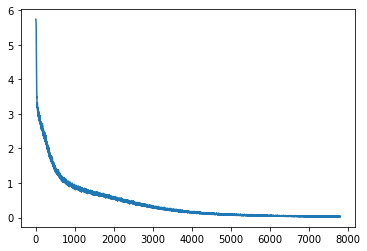

In [117]:
plot(losses)

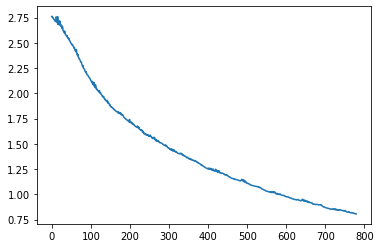

In [26]:
plot(losses_val)

In [29]:
""" Index2word """
en_index2word = dict(zip(en_tokenizer.word_index.values(), en_tokenizer.word_index.keys()))
fr_index2word = dict(zip(fr_tokenizer.word_index.values(), fr_tokenizer.word_index.keys()))

In [35]:
def infer_nmt(encoder_model, decoder_model, test_en_seq, en_vsize, fr_vsize):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """
    test_fr_seq = sents2sequences(fr_tokenizer, ['sos'], fr_vsize)
    test_en_onehot_seq = to_categorical(test_en_seq, num_classes=en_vsize)
    test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

    enc_outs, enc_last_state,enc_last_c = encoder_model.predict(test_en_onehot_seq)
    dec_state_h = enc_last_state
    dec_state_c = enc_last_c
    attention_weights = []
    fr_text = ''
    for i in range(20):
        dec_out, dec_state_h, dec_state_c,attention = decoder_model.predict([enc_outs, dec_state_h, 
                                                                   dec_state_c, test_fr_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_fr_seq = sents2sequences(fr_tokenizer, [fr_index2word[dec_ind]], fr_vsize)
        test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

        attention_weights.append((dec_ind, attention))
        fr_text += fr_index2word[dec_ind] + ' '

    return fr_text,attention_weights

In [36]:
""" Inferring with trained model """
test_en = ts_en_text[2]
print('Translating: {}'.format(test_en))

test_en_seq = sents2sequences(en_tokenizer, [test_en], pad_length=en_timesteps)
test_fr,attention_weights = infer_nmt(
    encoder_model=infer_enc_model, decoder_model=infer_dec_model,
    test_en_seq=test_en_seq, en_vsize=en_vsize, fr_vsize=fr_vsize)
print('\tFrench: {}'.format(test_fr[:-4]))

Translating: france is never nice during spring , but it is usually mild in november .

	French: la états unis est jamais agréable en avril mais il est jamais agréable en janvier 


In [33]:
def plot_attention_weights(encoder_inputs, attention_weights, en_id2word, fr_id2word, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
    attention_mat = np.transpose(np.array(mats))

    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    print(dec_inputs)
    ax.set_xticklabels([fr_id2word[inp] if inp != 0 else "<Res>" for inp in dec_inputs])
    ax.set_yticklabels([en_id2word[inp] if inp != 0 else "<Res>" for inp in encoder_inputs.ravel()])

    ax.tick_params(labelsize=32)
    ax.tick_params(axis='x', labelrotation=90)

[10, 37, 38, 2, 11, 21, 5, 57, 8, 6, 2, 11, 21, 5, 47, 4]


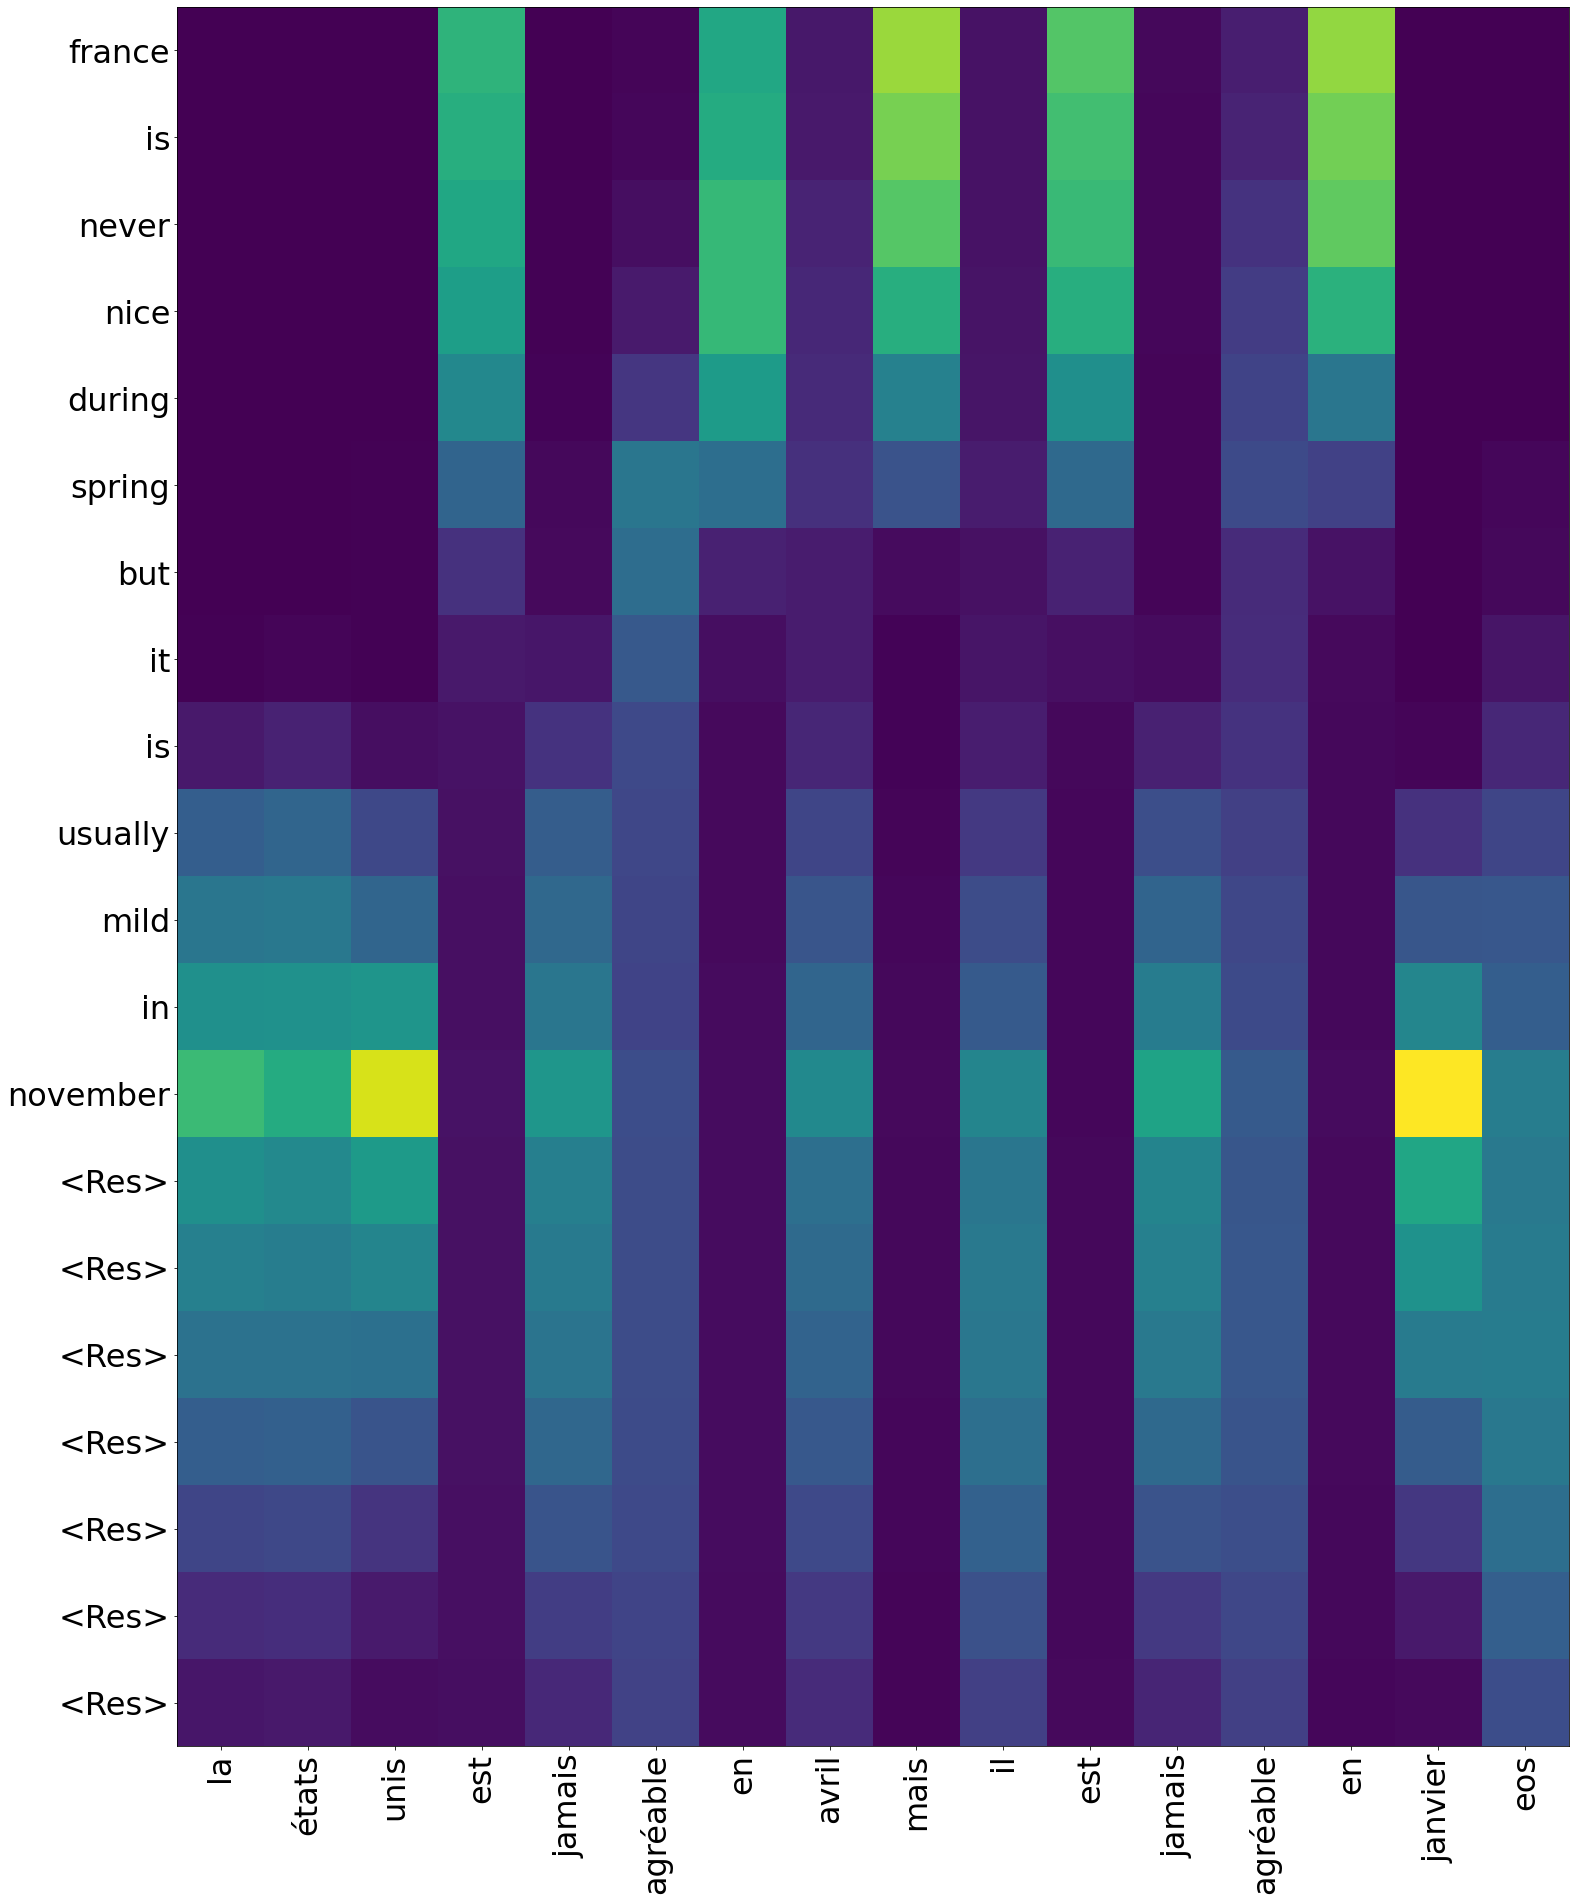

In [39]:
plot_attention_weights(test_en_seq, attention_weights, en_index2word, fr_index2word)